In [1]:
import pandas as pd 
DATASET = "amazon_reviews_us_Grocery_v1_00.tsv"
BR_DATASET = "bad-reviews.csv"
ENTRIES_WANTED = 10000
import logging
import warnings
import sys
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import random
import math
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')
logging.disable(sys.maxsize)



In [2]:
dataset = pd.read_table(DATASET, error_bad_lines=False, header=0, warn_bad_lines=False) 
# there are some malformed entries the dataset... let's ignore those for now


In [3]:
### Let's see what the dataset looks like... 
dataset.head()


,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date
0,US,42521656,R26MV8D0KG6QI6,B000SAQCWC,159713740,"The Cravings Place Chocolate Chunk Cookie Mix,...",Grocery,5,0.0,0.0,N,Y,Using these for years - love them.,"As a family allergic to wheat, dairy, eggs, nu...",2015-08-31
1,US,12049833,R1OF8GP57AQ1A0,B00509LVIQ,138680402,"Mauna Loa Macadamias, 11 Ounce Packages",Grocery,5,0.0,0.0,N,Y,Wonderful,"My favorite nut. Creamy, crunchy, salty, and ...",2015-08-31
2,US,107642,R3VDC1QB6MC4ZZ,B00KHXESLC,252021703,Organic Matcha Green Tea Powder - 100% Pure Ma...,Grocery,5,0.0,0.0,N,N,Five Stars,This green tea tastes so good! My girlfriend l...,2015-08-31
3,US,6042304,R12FA3DCF8F9ER,B000F8JIIC,752728342,15oz Raspberry Lyons Designer Dessert Syrup Sauce,Grocery,5,0.0,0.0,N,Y,Five Stars,I love Melissa's brand but this is a great sec...,2015-08-31
4,US,18123821,RTWHVNV6X4CNJ,B004ZWR9RQ,552138758,"Stride Spark Kinetic Fruit Sugar Free Gum, 14-...",Grocery,5,0.0,0.0,N,Y,Five Stars,good,2015-08-31


In [4]:
#lots of nan values... :( 
dataset.isnull().sum()

marketplace           0
customer_id           0
review_id             0
product_id            0
product_parent        0
product_title         0
product_category      0
star_rating          22
helpful_votes        23
total_votes          23
vine                 23
verified_purchase    23
review_headline      34
review_body          88
review_date          65
dtype: int64

In [5]:
# Lots of spammy duplicate reviews...might be worth checking if the same person is duplicating the reviews across multiple products

# Additions, because maybe same review_body is not duplicate i.e. "Good" as review.
x = dataset[dataset['review_body'].duplicated() == True]
x = x[dataset['customer_id'].duplicated() == True] # ADDED THIS
x = x[dataset['product_id'].duplicated() == True] # ADDED THIS
print(len(x))
x.head()

75144


,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date
2323,US,32433311,R3DPQJFH05T0HS,B00OZYNGUS,228095196,Viva Naturals - The FINEST Raw Organic Chia Se...,Grocery,5,0.0,0.0,N,Y,Great product.,I've been using this to help keep me from snac...,2015-08-31
2330,US,130585,R3IOACXWPYTRUP,B00HZ7HSTW,885171844,Beantown Roasters K Cups Variety Packs,Grocery,5,0.0,1.0,N,Y,The Office like it!,These were purchased for an office and they lo...,2015-08-31
2401,US,14100648,RA8F0DF5OJH3J,B000WV0RW8,653213046,Healthworks Chia Seeds 3lb 6lb Parent,Grocery,5,0.0,0.0,N,Y,GREAT! Thanks So much and God bless,GREAT! Thanks So much and God bless! &#60;&#...,2015-08-31
2436,US,43554935,RK0TC9FRNUL55,B00HQ3ZPJA,220133938,Chia Seeds,Grocery,5,0.0,0.0,N,Y,Five Stars,As advertised.,2015-08-31
2541,US,168472,R2WFNGP0E0ZLXW,B006ZMYLKC,322601427,Keurig,Grocery,5,0.0,0.0,N,Y,Five Stars,Satisfied,2015-08-31


In [6]:
#remove NaNs from the dataset  for now...
dataset = dataset.dropna()

In [7]:
def filter_heuristic(row):
    '''
    determine if a row is a negative review based on its score. Potentially extend it to include sentiment analysis 
    and presence of specific negative words 
    '''
    return row["star_rating"].astype(int) <=3

In [8]:
negative_rows = dataset.loc[filter_heuristic]
negative_rows.head()

,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date
5,US,23649464,RIG9AWFOGRDVO,B00AL6QBZ6,681475449,Herr's Popcorn Hot Cheese 1 Oz (Pack of 30),Grocery,2,1.0,1.0,N,Y,Not Happy,The popcorn was stale.,2015-08-31
9,US,19624355,R1ODXB3C9UP3NL,B00J074W94,2499702,"Orgain Organic Plant Based Protein Powder, Pac...",Grocery,1,1.0,3.0,N,N,Disgusting now and difficult on digestion,Used to be a decent product. Disgusting now a...,2015-08-31
17,US,22765168,R3T6TTD2IN0EFZ,B00XDXMLL2,971154239,"Skippy Creamy Peanut Butter, with Salted Caram...",Grocery,1,4.0,4.0,N,N,"1 Out Of 5 Of My Co-Workers Thought It Was ""Okay""",I bought this from a local super market on a w...,2015-08-31
23,US,35636887,R9MISLBRG08FX,B00DBSFXUA,294404974,"Keebler Town House Pita Crackers, 9.5 Ounce",Grocery,1,0.0,0.0,N,Y,pita crackers,not craze about these. nothing really wrong wi...,2015-08-31
26,US,12650237,R2A9O8CWZ1PP74,B0083GJKR2,868929824,"Eclipse Sugar Free Gum, Spearmint, 120 Piece B...",Grocery,3,0.0,0.0,N,Y,Three Stars,it's gum..,2015-08-31


In [9]:
sorted_negative_rows = negative_rows.sort_values("product_id")
sorted_negative_rows.head() # ADDITION JUST TO CHECK

,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date
1975011,US,14434517,R25ATZCV5FBJMV,0805470867,518591127,Communion Bread Pack of 500,Grocery,2,3.0,4.0,N,Y,The only thing my church has ever complained a...,I'm the pastor of a church plant and the only ...,2012-10-16
1365978,US,47145,RUI9CRY6RZNRB,0805470867,518591127,Communion Bread Pack of 500,Grocery,1.0,0.0,0.0,N,Y,I HATE IT,what is that thing<br />it doesn't crunch like...,2014-02-21
1961839,US,37403535,R37YYRMOE7K2TB,0805470867,518591127,Communion Bread Pack of 500,Grocery,1,1.0,1.0,N,Y,Communion bread,"I purchased 3 boxes, two of them the experatio...",2012-11-11
78777,US,41394716,R2QAW3WQRYVQF5,0805470867,518591127,Communion Bread Pack of 500,Grocery,3,0.0,0.0,N,Y,Not what expected,"This came in a flimsy cardboard box, squished....",2015-08-04
1845770,US,11312642,R3M9ORU1I9L2C3,0805470867,518591127,Communion Bread Pack of 500,Grocery,2,0.0,0.0,N,Y,Gross,These things taste nothing like the communion ...,2013-02-18


In [10]:
def generate_wordcloud(text):
    wordcloud = WordCloud(width = 5000, height = 5000, random_state=1, background_color='salmon', colormap='Pastel1',
                          collocations=False, stopwords = STOPWORDS).generate(text)
    plt.imshow(wordcloud)

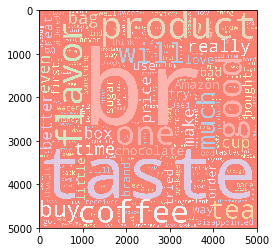

In [11]:
# generate a naive word cloud without any preprocessing....
generate_wordcloud(" ".join(sorted_negative_rows["review_body"]))

In [12]:
sorted_rows = dataset.sort_values("product_id")
sorted_rows["avg_rating"] = ""
sorted_rows.head(5)

,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date,avg_rating
115213,US,886579,R18D9WDJHHZNWA,0268956898,674048074,Delgada coffee infused with Chaga 28 Sachets p...,Grocery,5,7.0,8.0,N,N,You will lose weight and feel great..,This coffee has been a life saver for me.. I s...,2015-07-22,
1569777,US,41921418,R1QUUN8C0ZF7C7,0657745316,31867226,100 Percent All Natural Vanilla Extract,Grocery,5,1.0,1.0,N,N,Best vanilla I've ever had,"No sugar, no GMO garbage, no fillers that come...",2013-10-11,
1299951,US,20405919,R105NG5PE8CMHK,0681727810,680395208,Beemster Gouda - Aged 18/24 Months - App. 1.5 Lbs,Grocery,5,4.0,4.0,N,Y,"This cheese is so good, just wish it didn't co...","This cheese is so good, just wish it didn't co...",2014-04-01,
1941826,US,36034133,R26D6HKBPP95HB,0700026444,597586824,Pure Darjeeling Tea: Loose Leaf,Grocery,5,2.0,2.0,N,N,Terrific Tea!,"This is my absolute, undisputed favorite tea r...",2012-12-06,
715823,US,50510678,R440L1BV7SZ18,0786960159,449320317,Axis and Allies 1942 Second Edition: A Wwii St...,Grocery,5,0.0,0.0,N,Y,Five Stars,1st class,2015-01-05,


In [13]:
starRating = sorted_rows.iloc[0]["star_rating"]
productId = sorted_rows.iloc[0]["product_id"]
print(len(sorted_rows))

i = 0

while i < len(sorted_rows):
    productId = sorted_rows.iloc[i]["product_id"]
    sum = 0
    skip = 1

    sum += int(sorted_rows.iloc[i]["star_rating"])

    sameProduct = True

    while(sameProduct):
        if((i + skip) == len(sorted_rows)):
            sameProduct = False
        elif(sorted_rows.iloc[i + skip]["product_id"] == productId):
            sum += int(sorted_rows.iloc[i + skip]["star_rating"])
            skip += 1
        else:
            sameProduct = False

    avgRating = round((sum / skip), 2)

    for j in range(skip):
        sorted_rows.iat[(i + j),15] = avgRating
    
    i += 1
    i += (skip - 1)

sorted_rows.head(25)


2393238


,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date,avg_rating
115213,US,886579,R18D9WDJHHZNWA,0268956898,674048074,Delgada coffee infused with Chaga 28 Sachets p...,Grocery,5,7.0,8.0,N,N,You will lose weight and feel great..,This coffee has been a life saver for me.. I s...,2015-07-22,5.0
1569777,US,41921418,R1QUUN8C0ZF7C7,0657745316,31867226,100 Percent All Natural Vanilla Extract,Grocery,5,1.0,1.0,N,N,Best vanilla I've ever had,"No sugar, no GMO garbage, no fillers that come...",2013-10-11,5.0
1299951,US,20405919,R105NG5PE8CMHK,0681727810,680395208,Beemster Gouda - Aged 18/24 Months - App. 1.5 Lbs,Grocery,5,4.0,4.0,N,Y,"This cheese is so good, just wish it didn't co...","This cheese is so good, just wish it didn't co...",2014-04-01,5.0
1941826,US,36034133,R26D6HKBPP95HB,0700026444,597586824,Pure Darjeeling Tea: Loose Leaf,Grocery,5,2.0,2.0,N,N,Terrific Tea!,"This is my absolute, undisputed favorite tea r...",2012-12-06,5.0
715823,US,50510678,R440L1BV7SZ18,0786960159,449320317,Axis and Allies 1942 Second Edition: A Wwii St...,Grocery,5,0.0,0.0,N,Y,Five Stars,1st class,2015-01-05,5.0
1395096,US,41650959,R30F1NHZYFDBLE,0805470867,518591127,Communion Bread Pack of 500,Grocery,1,0.0,0.0,N,Y,Communion bread,The taste & texture of this product is terribl...,2014-02-05,3.55
1713269,US,10574871,R3V4ZX64YU2EB3,0805470867,518591127,Communion Bread Pack of 500,Grocery,5,0.0,0.0,N,Y,Broadman products are excellent,I have been very pleased with this product...a...,2013-06-08,3.55
1738286,US,11425554,R263F2Q3CR0JJG,0805470867,518591127,Communion Bread Pack of 500,Grocery,5,0.0,2.0,N,Y,WORSHIP,The communion bread you take to let my Lord kn...,2013-05-18,3.55
85156,US,21557738,RQQGEZP7Y51CA,0805470867,518591127,Communion Bread Pack of 500,Grocery,5,0.0,0.0,N,Y,Five Stars,what I needed,2015-08-02,3.55
1539819,US,44727551,R1RQYKPG2BBZPW,0805470867,518591127,Communion Bread Pack of 500,Grocery,5,0.0,0.0,N,Y,The package was well recieved and we enjoyed i...,Awesome packing and easy to use. Made it so ea...,2013-11-04,3.55


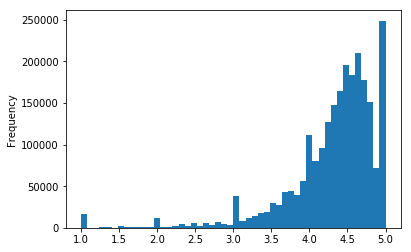

In [14]:
ax = sorted_rows["avg_rating"].plot.hist(bins = 50)

In [15]:
lds = len(dataset)


onePointFive = sorted_rows.loc[(sorted_rows["avg_rating"] <= 1.5) & (sorted_rows["avg_rating"] >= 1)]
onePointFiveRatio = len(onePointFive)/lds
print(onePointFiveRatio)
two = sorted_rows.loc[(sorted_rows["avg_rating"] <= 2.0) & (sorted_rows["avg_rating"] > 1.5)]
twoRatio = len(two)/lds
print(twoRatio)
twoPointFive = sorted_rows.loc[(sorted_rows["avg_rating"] <= 2.5) & (sorted_rows["avg_rating"] > 2.0)]
twoPointFiveRatio = len(twoPointFive)/lds
print(twoPointFiveRatio)
three = sorted_rows.loc[(sorted_rows["avg_rating"] <= 3.0) & (sorted_rows["avg_rating"] > 2.5)]
threeRatio = len(three)/lds
print(threeRatio)
threePointFive = sorted_rows.loc[(sorted_rows["avg_rating"] <= 3.5) & (sorted_rows["avg_rating"] > 3.0)]
threePointFiveRatio = len(threePointFive)/lds
print(threePointFiveRatio)
four = sorted_rows.loc[(sorted_rows["avg_rating"] <= 4.0) & (sorted_rows["avg_rating"] > 3.5)]
fourRatio = len(four)/lds
print(fourRatio)
fourPointFive = sorted_rows.loc[(sorted_rows["avg_rating"] <= 4.5) & (sorted_rows["avg_rating"] > 4.0)]
fourPointFiveRatio = len(fourPointFive)/lds
print(fourPointFiveRatio)
five = sorted_rows.loc[(sorted_rows["avg_rating"] <= 5.0) & (sorted_rows["avg_rating"] > 4.5)]
fiveRatio = len(five)/lds
print(fiveRatio)

0.008685304177854437
0.006449839088297946
0.007166441448781943
0.025591270070089142
0.03979545703352529
0.13195428118724506
0.3363355420564106
0.44402186493779555


In [16]:
badReviews = pd.read_csv(BR_DATASET) 

badReviews.head()

badReviewRatio = len(badReviews)/lds
print(badReviewRatio)

0.000356003038561146


In [17]:
def getEntries(dataset, ratio, entriesWanted):
    numEntries = math.floor(ratio*entriesWanted)
    samplingSetSize = len(dataset)
    entries = 0

    collectedRows = pd.DataFrame(columns=['entry_id', 'marketplace', 'customer_id', 'review_id', 'product_id', 'product_parent', 'product_title', 'product_category', 'star_rating', 'helpful_votes', 'total_votes', 'vine', 'verified_purchase', 'review_headline', 'review_body', 'review_date', 'avg_review'])

    while (entries < numEntries):
        index = random.randint(0, samplingSetSize)

        product_id = sorted_rows.iloc[index]['product_id']
        reviews = sorted_rows.loc[sorted_rows["product_id"] == product_id]
        entries += len(reviews)

        if(len(reviews) > 0):
            print(len(reviews))

        for i in range(len(reviews)):
            collectedRows = collectedRows.append(reviews.iloc[i])

    return collectedRows

def subset(entriesWanted):
    dsOut = collectedRows = pd.DataFrame(columns=['entry_id', 'marketplace', 'customer_id', 'review_id', 'product_id', 'product_parent', 'product_title', 'product_category', 'star_rating', 'helpful_votes', 'total_votes', 'vine', 'verified_purchase', 'review_headline', 'review_body', 'review_date', 'avg_review'])

    entries = getEntries(onePointFive, onePointFiveRatio, entriesWanted) #1.0 - 1.5
    for i in range(len(entries)):
        dsOut = dsOut.append(entries.iloc[i])
    entries = getEntries(two, twoRatio, entriesWanted) # 1.5 - 2.0
    for i in range(len(entries)):
        dsOut = dsOut.append(entries.iloc[i])
    entries = getEntries(twoPointFive, twoPointFiveRatio, entriesWanted) # 2.0 - 2.5
    for i in range(len(entries)):
        dsOut = dsOut.append(entries.iloc[i])
    entries = getEntries(three, threeRatio, entriesWanted) # 2.5 - 3.0
    for i in range(len(entries)):
        dsOut = dsOut.append(entries.iloc[i])
    entries = getEntries(threePointFive, threePointFiveRatio, entriesWanted) # 3.0 - 3.5
    for i in range(len(entries)):
        dsOut = dsOut.append(entries.iloc[i])
    entries = getEntries(four, fourRatio, entriesWanted) # 3.5 - 4.0
    for i in range(len(entries)):
        dsOut = dsOut.append(entries.iloc[i])
    entries = getEntries(fourPointFive, fourPointFiveRatio, entriesWanted) # 4.0 - 4.5
    for i in range(len(entries)):
        dsOut = dsOut.append(entries.iloc[i])
    entries = getEntries(five, fiveRatio, entriesWanted) # 4.5 - 5.0
    for i in range(len(entries)):
        dsOut = dsOut.append(entries.iloc[i])

    return dsOut

subSample = subset(ENTRIES_WANTED)
print(len(subSample))
subSample.head(25)

32
32
20
1
338
10
19
338
13
19
4
2
1
30
3
10
32
77
73
9
41
128
12
63
14
48
41
22
1682
72
104
129
400
1074
20
3
17
245
3461
28
8
22
231
65
222
8
49
31
27
23
33
35
18
315
69
75
225
8
415
5
63
938
45
77
55
2
6
1570
13307


,entry_id,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date,avg_review,avg_rating
1384092,NaN,US,52780546,R342W6RCBMBSCE,B0000D9N9S,5288203,Tiger Processed Gruyere 6-Wedges - Value Bundl...,Grocery,5,7.0,7.0,N,Y,Delicious Cheese -- ridiculous price!,Tiger Cheese has been my favorite for many yea...,2014-02-11,NaN,4.28
1818536,NaN,US,51812765,R3FISWEAW2PMWT,B0000D9N9S,5288203,Tiger Processed Gruyere 6-Wedges - Value Bundl...,Grocery,5.0,0.0,1.0,N,Y,Great Cheese,Difficult to find. Delicious snacking alone o...,2013-03-11,NaN,4.28
2162151,NaN,US,35010695,R2AOFTVEP5GH2I,B0000D9N9S,5288203,Tiger Processed Gruyere 6-Wedges - Value Bundl...,Grocery,5.0,1.0,1.0,N,N,The only cheese for quiche lorraine,"I've used this for about 25 years, have no ide...",2011-06-09,NaN,4.28
873673,NaN,US,44184459,R1E9OVIA5AHB16,B0000D9N9S,5288203,Tiger Processed Gruyere 6-Wedges - Value Bundl...,Grocery,2,3.0,3.0,N,Y,NOT THE SAME PRODUCT AS BEFORE,"I have eaten this product for years, but no lo...",2014-11-11,NaN,4.28
2333446,NaN,US,40211633,R13LSLHPJZR8G5,B0000D9N9S,5288203,Tiger Processed Gruyere 6-Wedges - Value Bundl...,Grocery,5,0.0,0.0,N,N,I LOVE TIGER CHEESE!!,This cheese is just wonderful--the taste is di...,2008-07-24,NaN,4.28
2178431,NaN,US,35533876,R1B6BJ8IXO4IN0,B0000D9N9S,5288203,Tiger Processed Gruyere 6-Wedges - Value Bundl...,Grocery,5.0,0.0,0.0,N,Y,buy 6 oz only,Don't know why they invented a 4 oz package. I...,2011-04-07,NaN,4.28
1194698,NaN,US,52164928,ROVV8IFUXZFVO,B0000D9N9S,5288203,Tiger Processed Gruyere 6-Wedges - Value Bundl...,Grocery,1,0.0,0.0,N,Y,Excellent Cheesse that I remember when it was ...,UPDATE: $14.99 shipping is Price Gouging.<br ...,2014-06-13,NaN,4.28
1824534,NaN,US,35277952,R14AXJAFDLJ1CL,B0000D9N9S,5288203,Tiger Processed Gruyere 6-Wedges - Value Bundl...,Grocery,5.0,0.0,0.0,N,Y,Great Cheese!!,This brand (Tiger) until a short time ago was ...,2013-03-07,NaN,4.28
1972670,NaN,US,18373719,R3MZCEQ0FJBU9A,B0000D9N9S,5288203,Tiger Processed Gruyere 6-Wedges - Value Bundl...,Grocery,5,0.0,1.0,N,Y,Great Tiger Cheese,I love tiger cheese since a was a little girl ...,2012-10-20,NaN,4.28
1688975,NaN,US,35757967,RQP7B876QB5OP,B0000D9N9S,5288203,Tiger Processed Gruyere 6-Wedges - Value Bundl...,Grocery,5,0.0,0.0,N,Y,I AM ADDICTED TO THE CHEESE,"I am 82 years old, AS CHILD, AND INTO MY LATER...",2013-06-30,NaN,4.28


In [18]:
count = 0
print(len(subSample))
for i in range(len(badReviews)):
    review_id = badReviews.iloc[i]["review_id"]
    if ((subSample['review_id'] == review_id).any() == True):
        count += 1

numBadReviews = round(badReviewRatio * ENTRIES_WANTED)
if (count < numBadReviews):
    difference = numBadReviews - count
    for i in range(difference):
        index = random.randint(0, samplingSetSize)
        subSample = subSample.append(badReviews.iloc[index])

print(len(subSample))
print(count)

13307
13307
4


In [19]:
subSample.to_csv('subSampled_Reviews.csv')